# ABS Monthly Labour Force 6202

## Python set-up

In [1]:
# analytic imports
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd

import readabs as ra
from readabs import metacol as mc
import mgplot as mg

# local imports
from abs_helper import get_abs_data, collate_summary_data
from abs_plotting import (
    plot_rows_seas_trend,
    plot_rows_individually,
    plot_rows_collectively,
    iudts_from_row,
)


# pandas display settings
pd.options.display.max_rows = 9999
pd.options.display.max_columns = 999

# display all charts in this notebook ...
SHOW = True

## Get data from ABS

In [2]:
abs_dict, meta, source, RECENT = get_abs_data("6202.0")
plot_times = None, RECENT
plot_tags = "", "-recent"

In [3]:
for name, table in abs_dict.items():
    print(f"{name} {table.index[-1]}")
    break

6202001 2025-04


## Plot

### Labour force summary chart

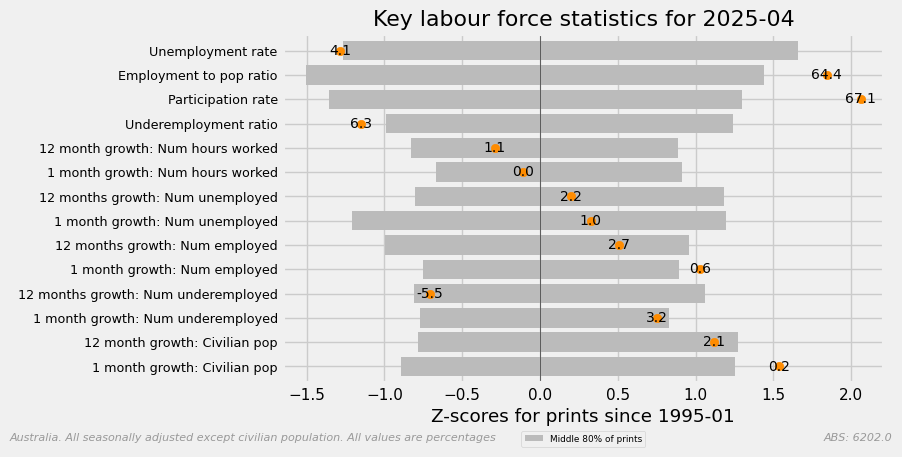

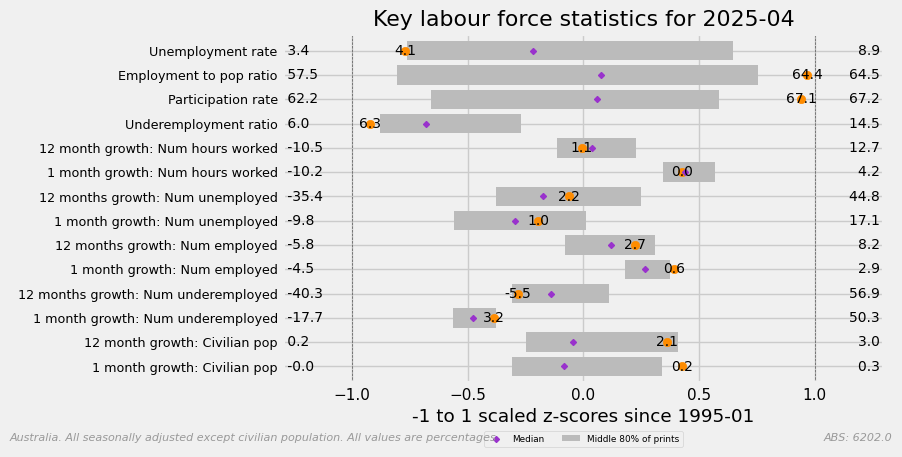

In [4]:
def summarise() -> None:
    """Summarise the data in the ABS dataset"""

    required = {
        # order from least to most important (ie. bottom to top)
        # chart label: [ABS code, growth over n periods]
        "1 month growth: Civilian pop": ("A84423091W", 1),
        "12 month growth: Civilian pop": ("A84423091W", 12),
        "1 month growth: Num underemployed": ("A85255719L", 1),
        "12 months growth: Num underemployed": ("A85255719L", 12),
        "1 month growth: Num employed": ("A84423043C", 1),
        "12 months growth: Num employed": ("A84423043C", 12),
        "1 month growth: Num unemployed": ("A84423046K", 1),
        "12 months growth: Num unemployed": ("A84423046K", 12),
        "1 month growth: Num hours worked": ("A84426277X", 1),
        "12 month growth: Num hours worked": ("A84426277X", 12),
        "Underemployment ratio": ("A85255724F", 0),
        "Participation rate": ("A84423051C", 0),
        "Employment to pop ratio": ("A84423054K", 0),
        "Unemployment rate": ("A84423050A", 0),
    }

    summary = collate_summary_data(required, abs_dict, meta)

    mg.summary_plot(
        summary,
        start="1995-01",
        title=f"Key labour force statistics for {abs_dict['6202001'].index[-1]}",
        rfooter=source,
        lfooter="Australia. All seasonally adjusted except civilian population. "
        "All values are percentages",
        show=SHOW,
        verbose=False,
    )


summarise()

### Sahm Rule

The Sahm Rule is designed to provide an indicator for when the economy has entered a recession, noting that GDP based indications of a recession are usually late to surface due to lags in data reporting. 

To calculate the Sahm Rule number, one compares the current three-month moving average to the lowest three-month moving average from the prior twelve months -- if that result is more than 0.50, then there is an extremely strong likelihood that we are in a recession.

_Note_: Arguable that the 50 basis point threshold is too low for Australia. Historically, 60 basis points looks like a better threshold

In [5]:
def highlight(ax, series, color, alpha=0.5) -> None:
    """Add highlights to a chart based on a Boolean series."""

    shading, start, previous = False, None, None
    for index, item in series.items():
        if item and not shading:
            shading, start = True, index
        if shading and not item:
            ax.axvspan(start, previous, color=color, alpha=alpha)
            shading = False
        previous = index
    if shading:
        ax.axvspan(start, previous, color=color, alpha=alpha)

In [6]:
def hack_legend(ax, color, alpha, label) -> None:
    """Add a dummy entry to the legend to allow for a title."""

    patch = Patch(facecolor=color, alpha=alpha, label=label)
    handles, _labels = ax.get_legend_handles_labels()
    _lgd = ax.legend(handles=[handles[0], patch], loc="best", fontsize=8)

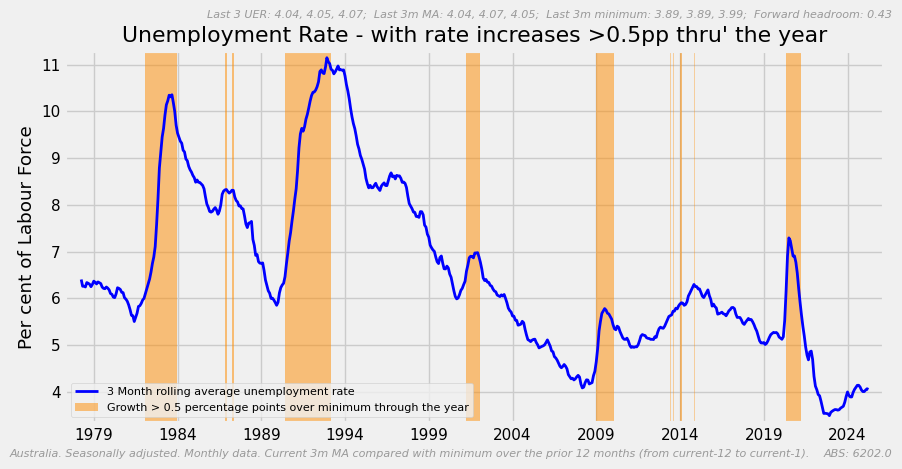

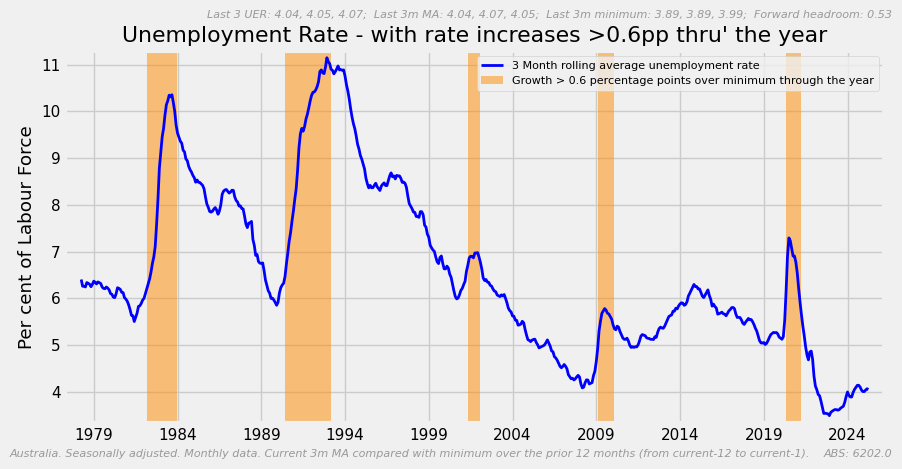

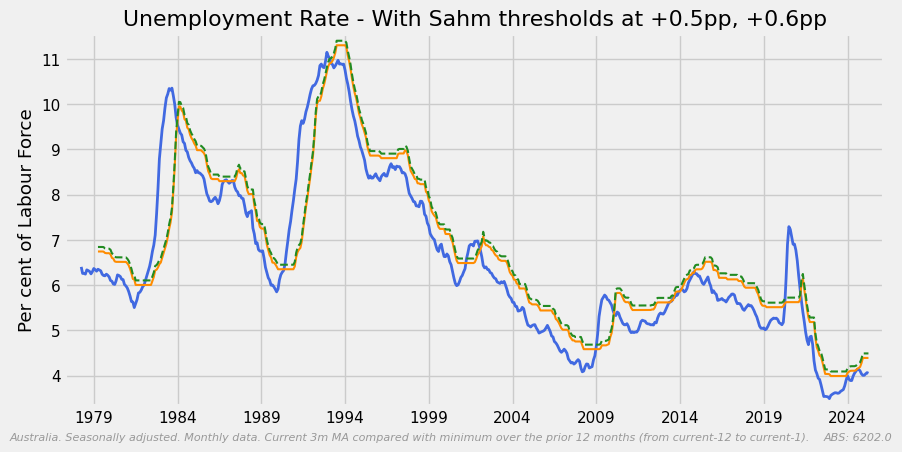

In [7]:
def sahm_plot(sahm_threshhold=0.5) -> tuple[pd.Series, pd.Series]:
    """Produce a chart that highlights periods where the unemployment rate
    has increased by more than a threshold."""

    range_color = "darkorange"
    range_alpha = 0.5

    uer_australia_sa = "A84423050A"
    m_uer = abs_dict["6202001"][uer_australia_sa]
    u3 = m_uer.rolling(3).mean()
    u3.name = "3 Month rolling average unemployment rate"
    ax = u3.plot(lw=2, c="blue")
    minimum = u3.rolling(12).min()
    sahm = minimum.shift(1) < u3 - sahm_threshhold  # shift for prior 12 months

    highlight(ax, sahm, color=range_color, alpha=range_alpha)
    hack_legend(
        ax,
        range_color,
        range_alpha,
        f"Growth > {sahm_threshhold} percentage points over minimum through the year",
    )

    mg.finalise_plot(
        ax,
        title=f"Unemployment Rate - with rate increases >{sahm_threshhold}pp thru' the year",
        ylabel="Per cent of Labour Force",
        y0=True,
        rfooter=source,
        lfooter="Australia. Seasonally adjusted. Monthly data. "
        + "Current 3m MA compared with minimum over the prior 12 months (from current-12 to current-1).",
        # contextual information ...
        rheader=f"Last 3 UER: {', '.join([str(x) for x in m_uer.iloc[-3:].round(2)])};  "
        + f"Last 3m MA: {', '.join([str(x) for x in u3.iloc[-3:].round(2)])};  "
        + f"Last 3m minimum: {', '.join([str(x) for x in minimum.iloc[-3:].round(2)])};  "
        + f"Forward headroom: {sahm_threshhold - (u3.iloc[-1] - minimum.iloc[-1]):.2f}",
        show=SHOW,
    )
    return u3, minimum.shift(1)


def multi_sahm():
    """Produce mulitiple Sahm charts woth different thresholds."""
    df, i_vals = pd.DataFrame(), []
    for i in 0.5, 0.6:
        u3, m = sahm_plot(i)
        df["Unemployment Rate 3 month MA"] = u3
        df[f"Prior 12 month minimum + {i}pp"] = m + i
        i_vals.append(i)

    mg.line_plot_finalise(
        df,
        title=f"Unemployment Rate - With Sahm thresholds at {', '.join([f'+{x}pp' for x in i_vals])}",
        ylabel="Per cent of Labour Force",
        y0=True,
        rfooter=source,
        lfooter="Australia. Seasonally adjusted. Monthly data. "
        + "Current 3m MA compared with minimum over the prior 12 months (from current-12 to current-1).",
        width=[2, 1.5, 1.5],
        style=["-", "-", "--"],
        show=SHOW,
    )


multi_sahm()

### Headline seasonally adjusted/trend charts

Warning expected dict argument: legend/<class 'tuple'>.


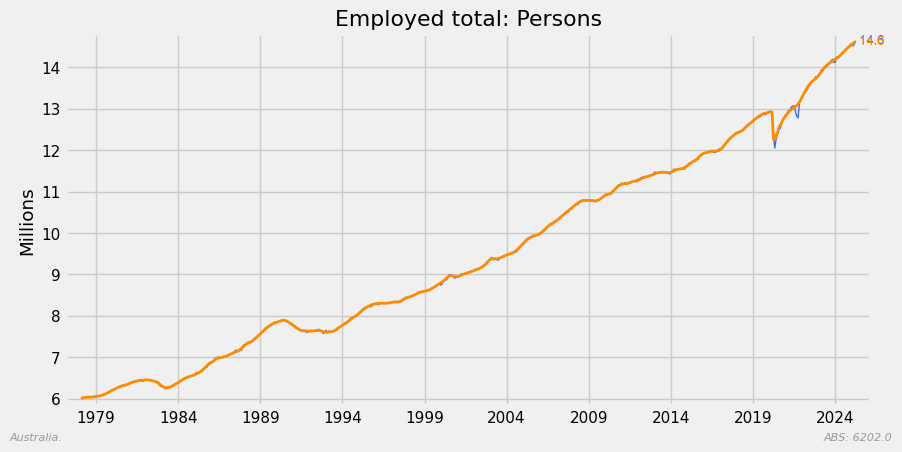

Warning expected dict argument: legend/<class 'tuple'>.


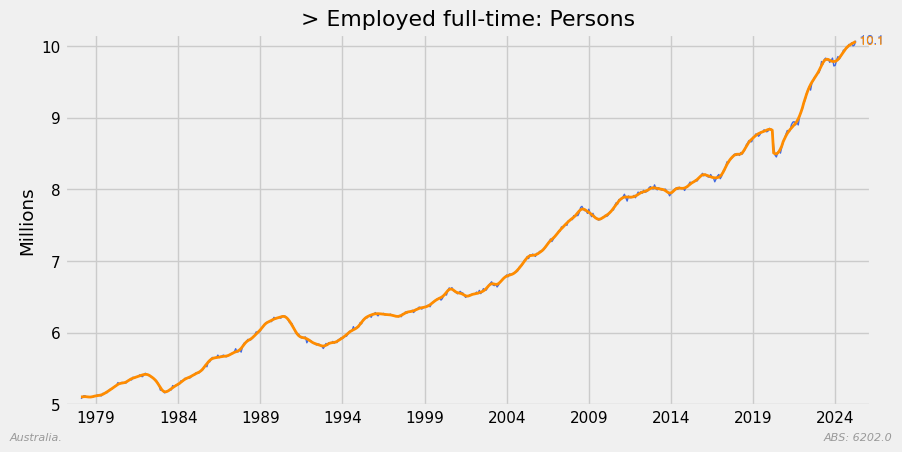

Warning expected dict argument: legend/<class 'tuple'>.


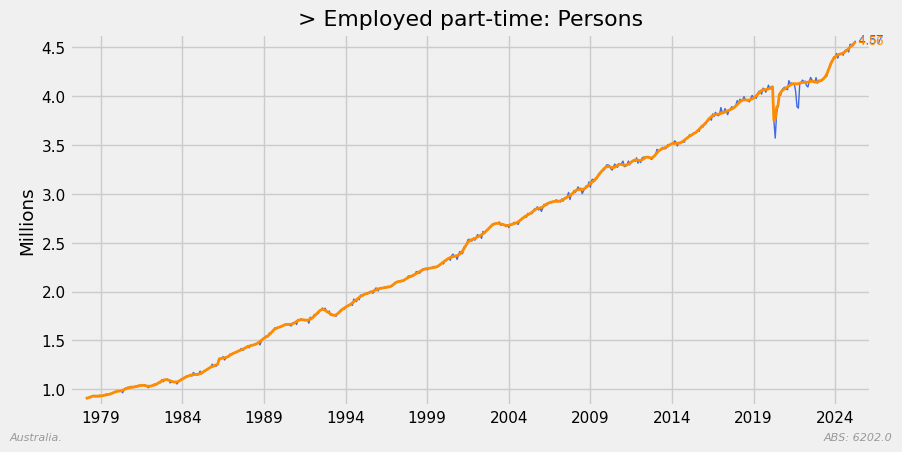

recalibrate(): Units not appropriately calibrated: Percent
Warning expected dict argument: legend/<class 'tuple'>.


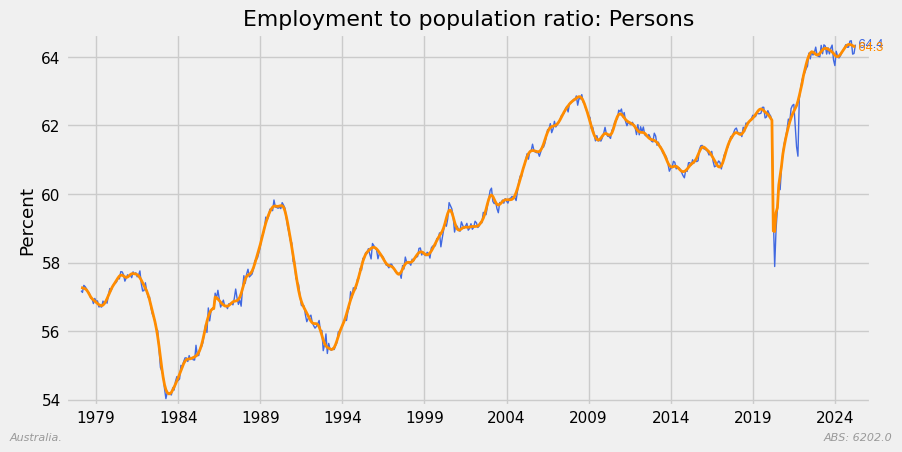

Warning expected dict argument: legend/<class 'tuple'>.


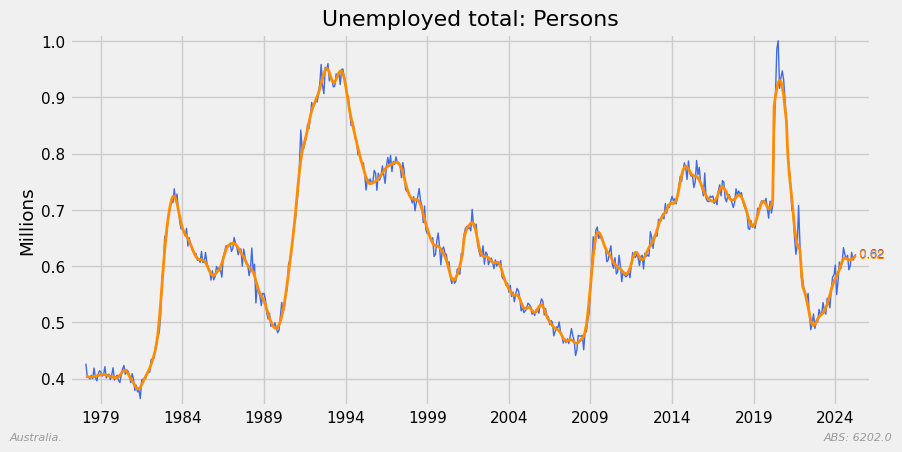

Warning expected dict argument: legend/<class 'tuple'>.


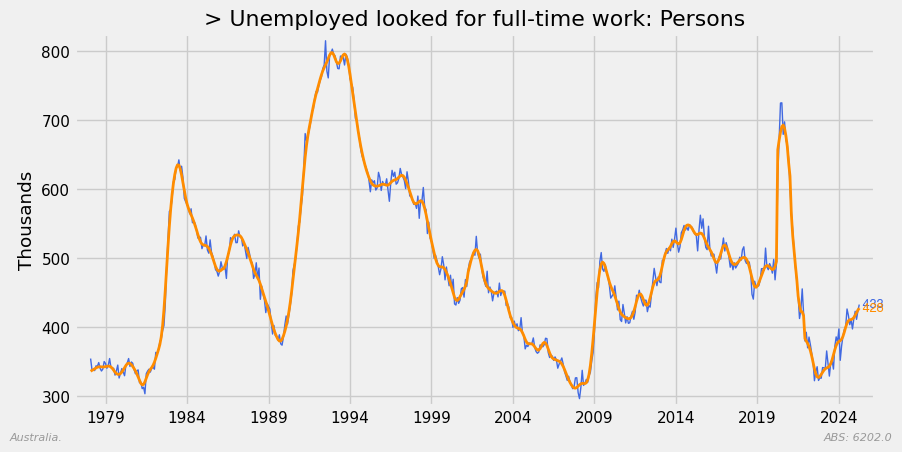

Warning expected dict argument: legend/<class 'tuple'>.


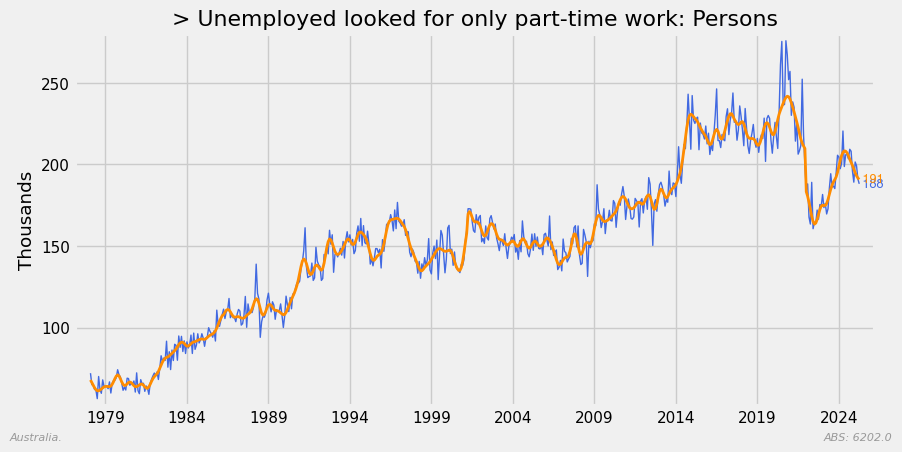

recalibrate(): Units not appropriately calibrated: Percent
Warning expected dict argument: legend/<class 'tuple'>.


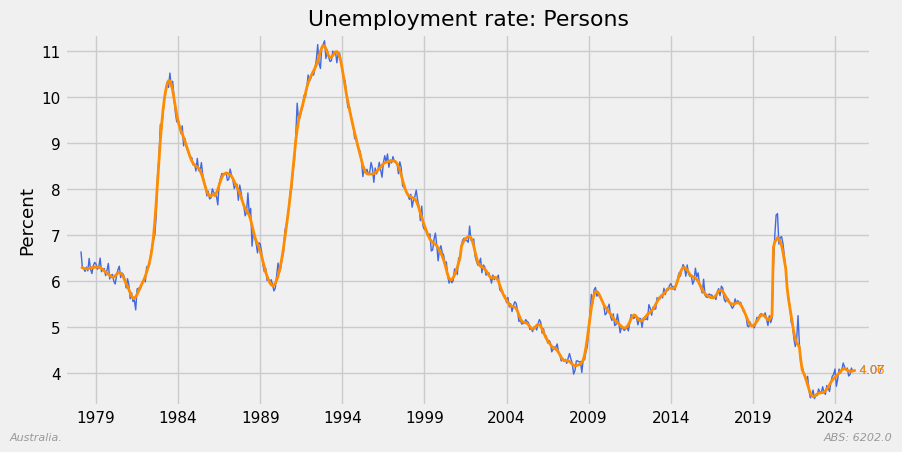

recalibrate(): Units not appropriately calibrated: Percent
Warning expected dict argument: legend/<class 'tuple'>.


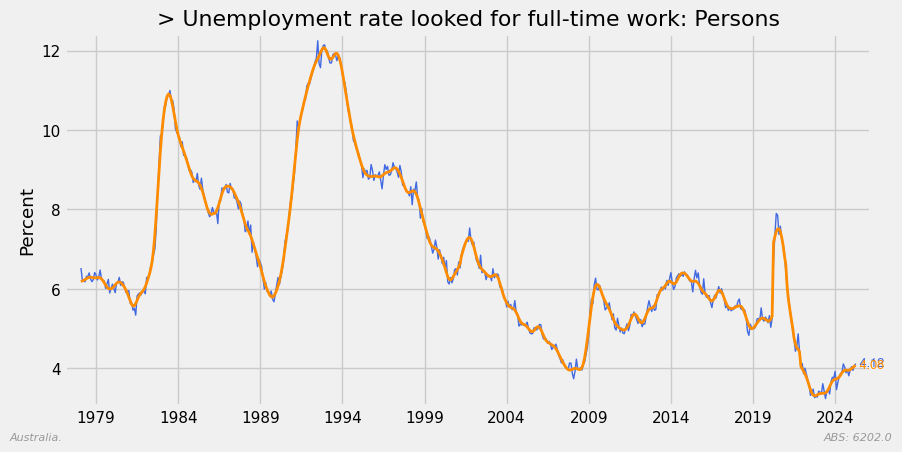

recalibrate(): Units not appropriately calibrated: Percent
Warning expected dict argument: legend/<class 'tuple'>.


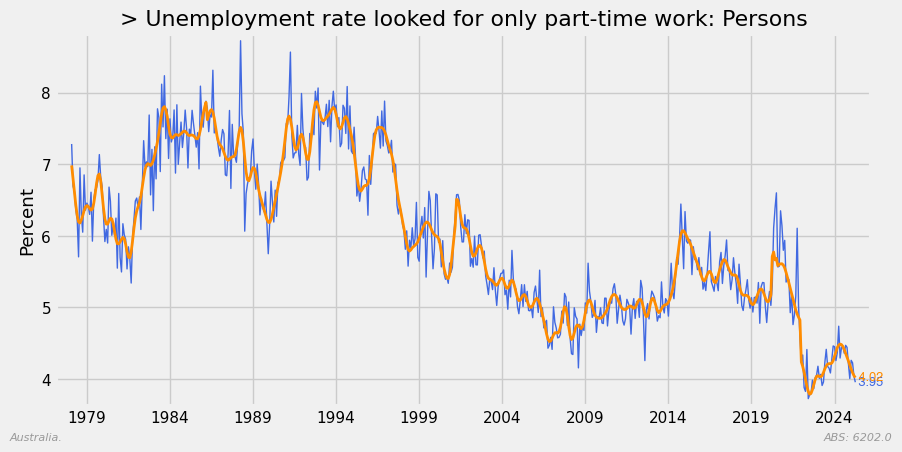

Warning expected dict argument: legend/<class 'tuple'>.


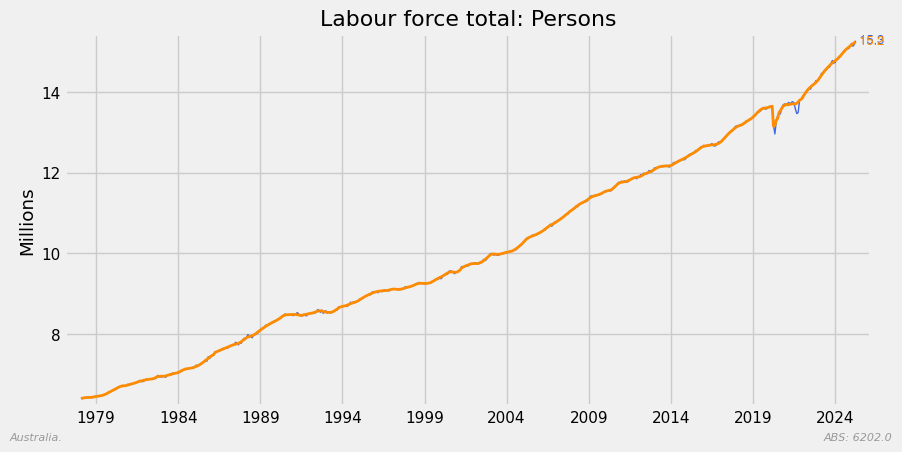

recalibrate(): Units not appropriately calibrated: Percent
Warning expected dict argument: legend/<class 'tuple'>.


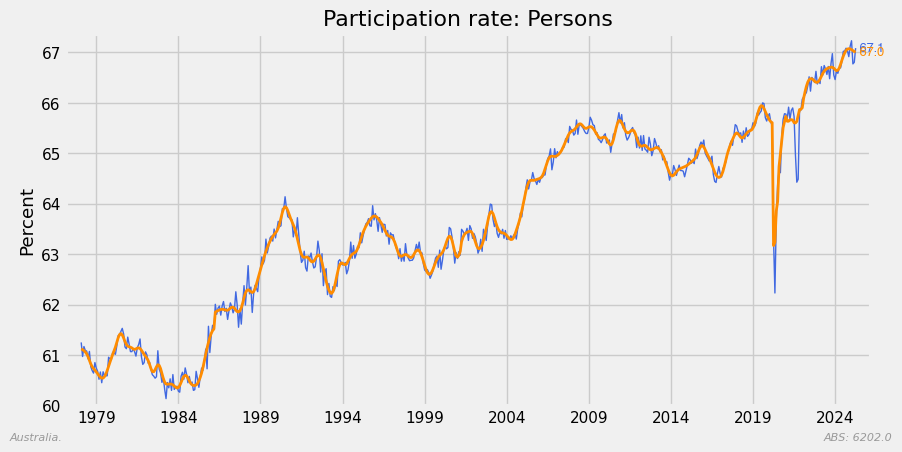

Warning expected dict argument: legend/<class 'tuple'>.


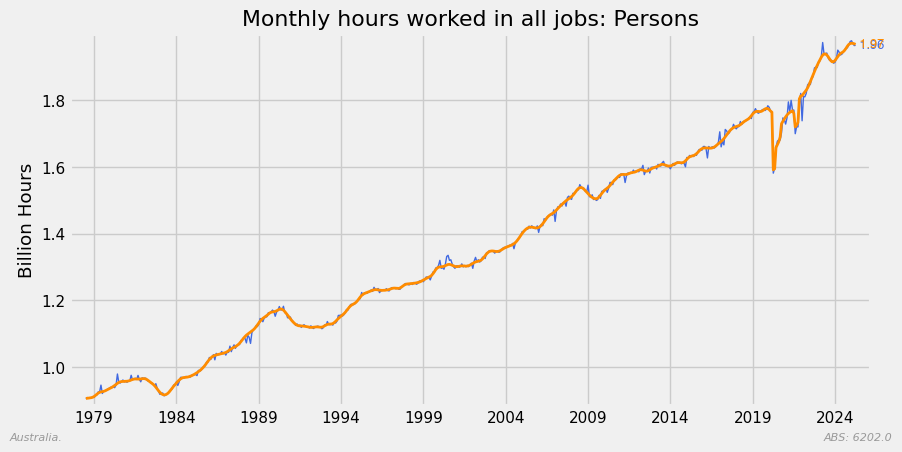

In [8]:
def headline_charts():
    """Produce headline charts."""

    selector1 = {
        "6202001": mc.table,
        "Persons": mc.did,
    }

    selector2 = {
        "Monthly hours worked in all jobs ;  Persons ;": mc.did,
        "6202019": mc.table,
    }

    for selector in (selector1, selector2):
        plot_rows_seas_trend(
            abs_dict,
            meta,
            selector,
            starts=plot_times,
            tags=plot_tags,
            rfooter=source,
            lfooter="Australia. ",
            verbose=False,
            show=SHOW,
        )


headline_charts()

### Checking for data revisions - in headline indicators

recalibrate(): Units not appropriately calibrated: Percent


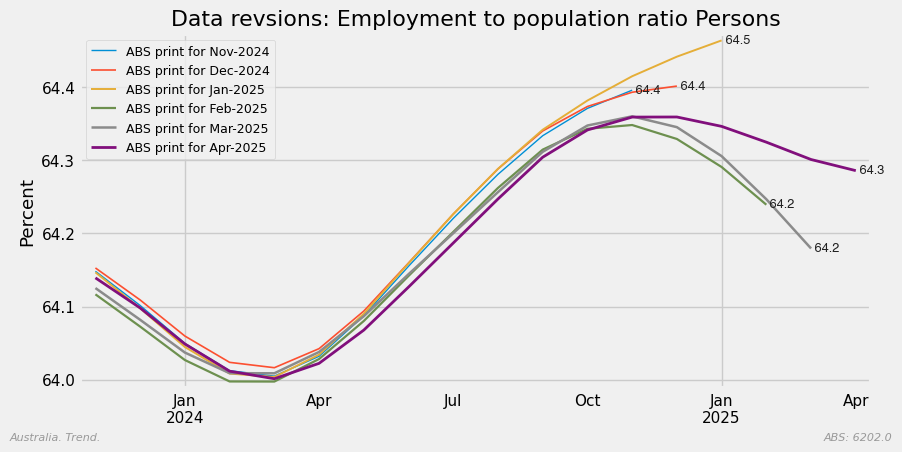

recalibrate(): Units not appropriately calibrated: Percent


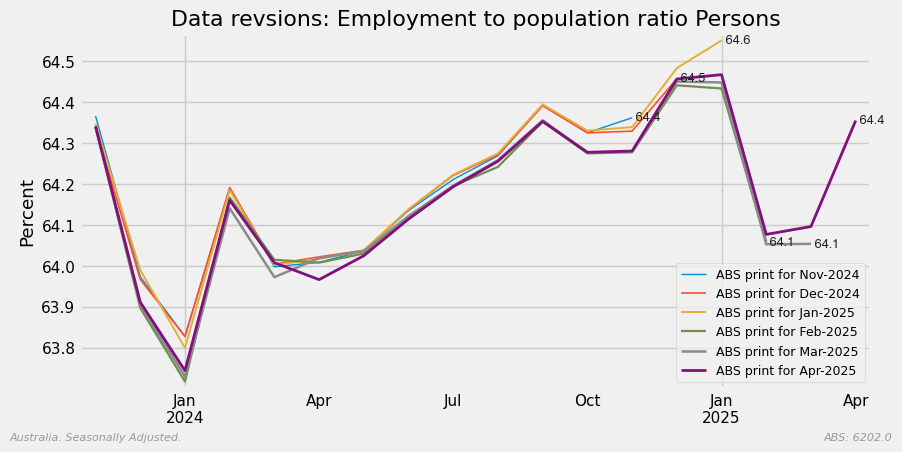

recalibrate(): Units not appropriately calibrated: Percent


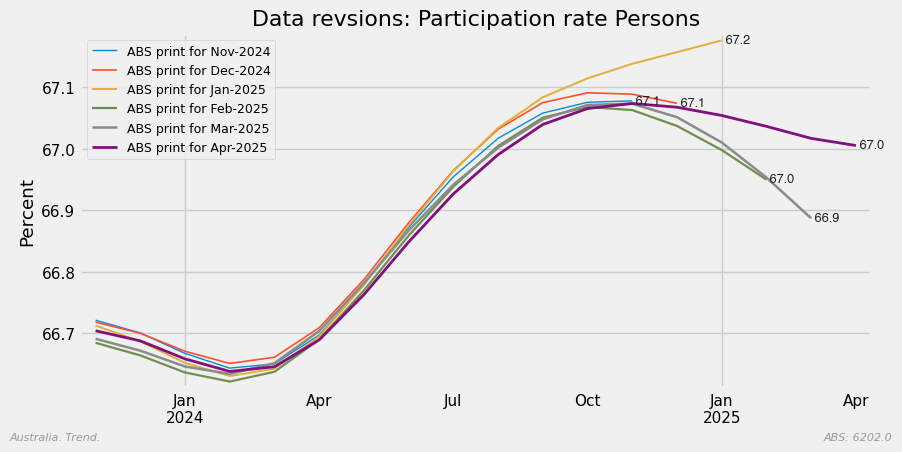

recalibrate(): Units not appropriately calibrated: Percent


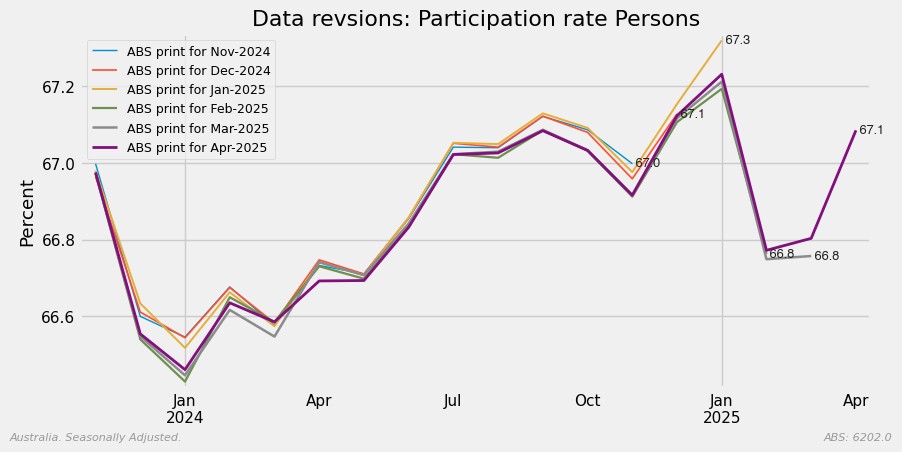

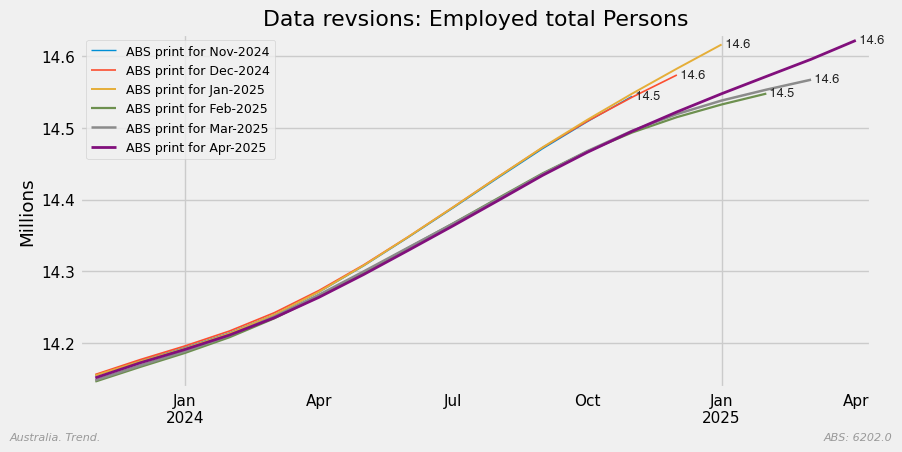

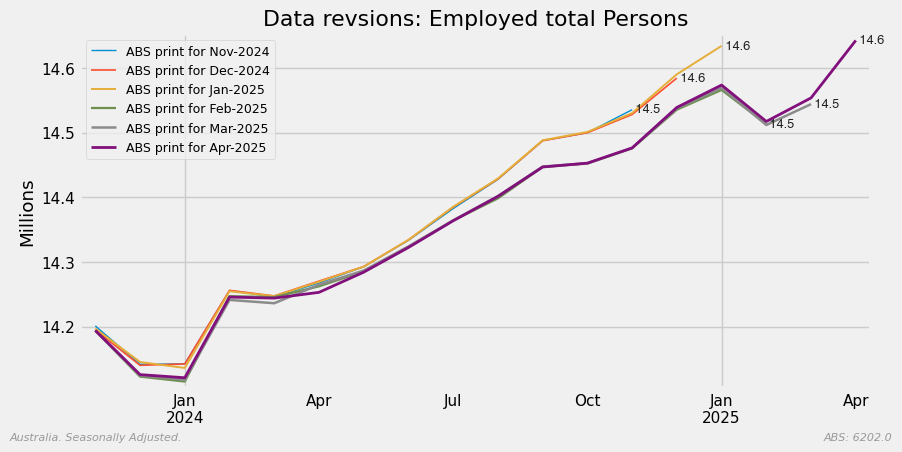

recalibrate(): Units not appropriately calibrated: Percent


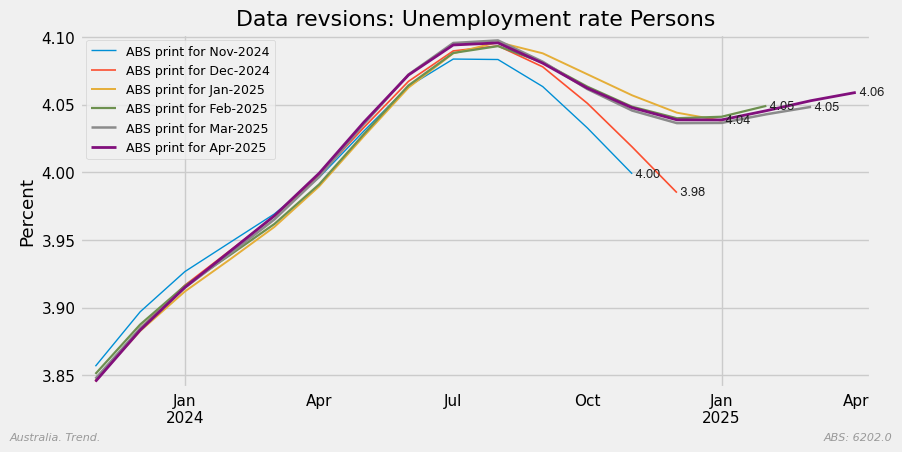

recalibrate(): Units not appropriately calibrated: Percent


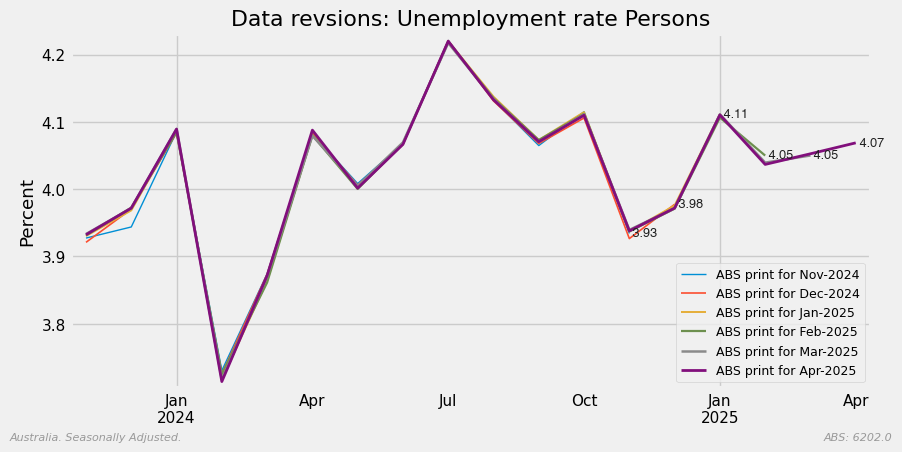

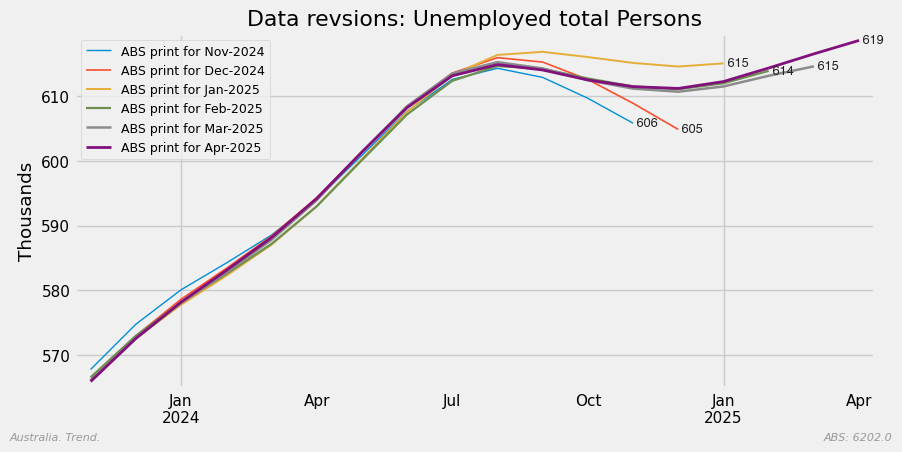

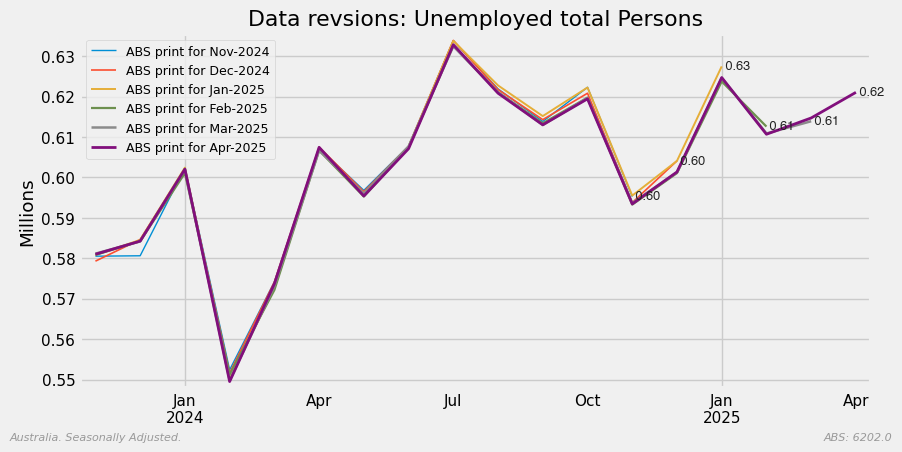

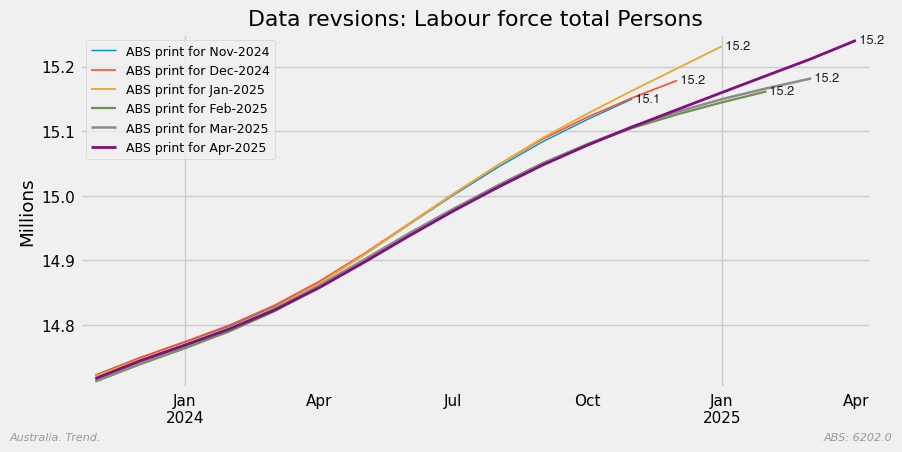

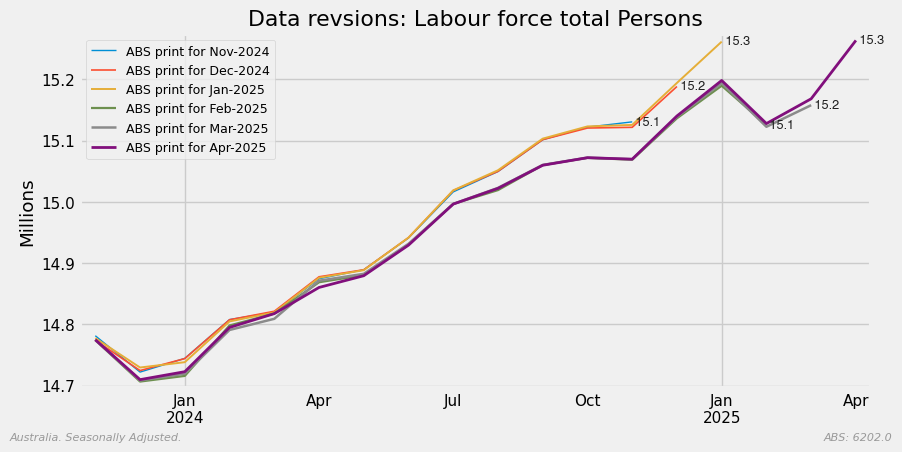

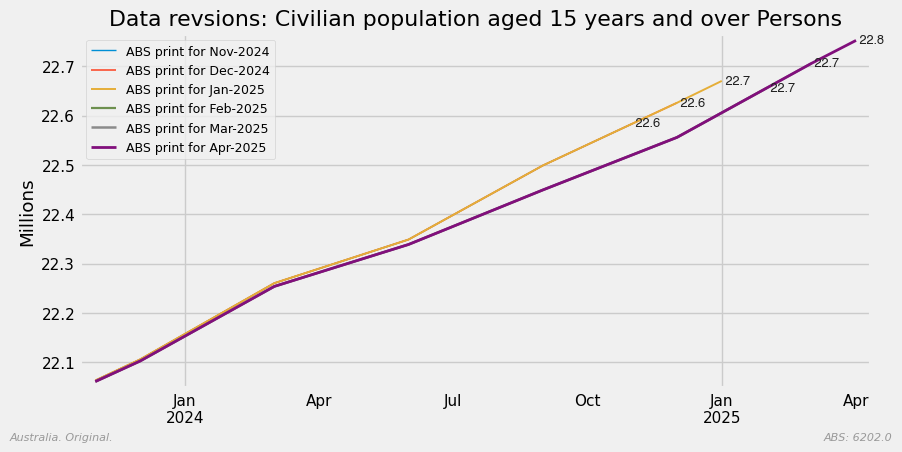

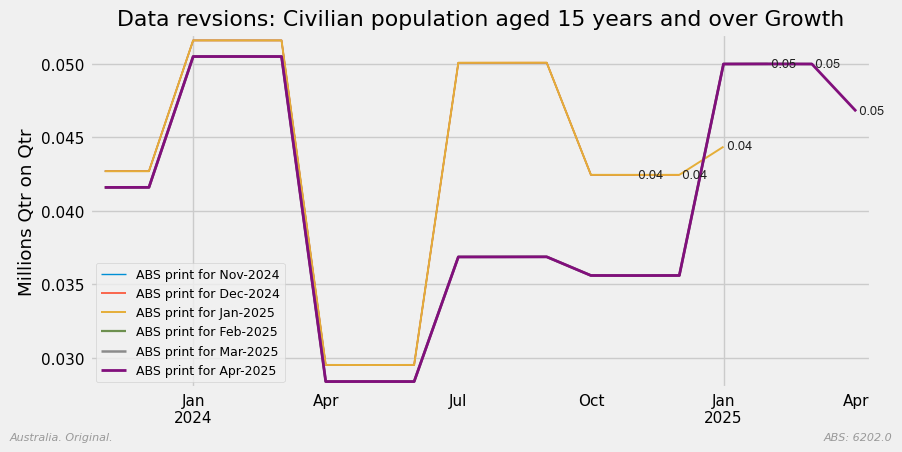

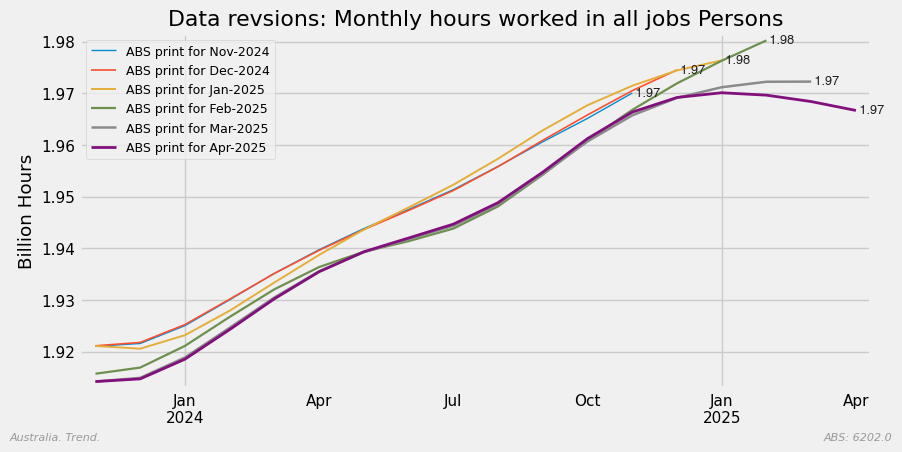

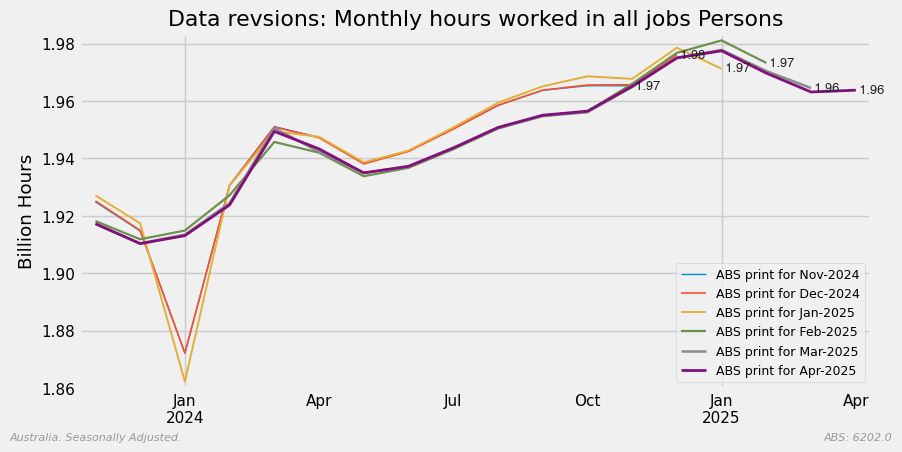

In [9]:
def compile_print_history(n: int, did: str, stype: str) -> tuple[pd.DataFrame, str]:
    """Compile the ABS print History.
    Arguments:
        n: number of months to collect
        did: the data item id
        stype: the series type
    Returns
    a tuple of the DataFrame and the metric units for the data."""

    repository = pd.DataFrame()
    history = None
    for _i in range(n):
        # iteratively collect the current then historic data ...
        seo = "6202001" if "hours" not in did else "6202019"
        d, m = ra.read_abs_cat(  # this is cached ...
            "6202.0", single_excel_only=seo, history=history
        )
        selector = {did: mc.did, stype: mc.stype, seo: mc.table}
        t, s, u = ra.find_abs_id(meta, selector)
        date = f"ABS print for {d[t].index[-1].strftime("%b-%Y")}"
        repository[date] = d[t][s]
        history = (d[t].index[-1] - 1).strftime("%b-%Y").lower()

    return repository, u


def data_revisions(n: int = 6) -> None:
    """Plot data revisions.
    Arguments:
        n: the number of months to plot."""

    dataset = [
        ("Employment to population ratio ;  Persons ;", 1),
        ("Participation rate ;  Persons ;", 1),
        ("Employed total ;  Persons ;", 2),
        ("Unemployment rate ;  Persons ;", 2),
        ("Unemployed total ;  Persons ;", 2),
        ("Labour force total ;  Persons ;", 2),
        ("Civilian population aged 15 years and over ;  Persons ;", 2),
        ("Monthly hours worked in all jobs ;  Persons ;", 2),
    ]

    for did, rounds in dataset:
        for stype in "Original", "Trend", "Seasonally Adjusted":
            if "Civilian" in did and stype != "Original":
                continue
            if "Civilian" not in did and stype == "Original":
                continue

            repository, units = compile_print_history(n, did, stype)
            repository, units = ra.recalibrate(repository, units)
            mg.revision_plot(
                repository,
                units,
                title=f"Data revsions: {did.replace(' ;', '').replace('  ', ' ')}",
                rfooter=source,
                lfooter=f"Australia. {stype}. ",
                legend={"loc": "best", "fontsize": 9},
                show=SHOW,
            )
            if did == "Civilian population aged 15 years and over ;  Persons ;":
                mg.revision_plot(
                    repository.diff(1),
                    f"{units} Qtr on Qtr",
                    title=f"Data revsions: {did.replace(' ;', '').replace('  Persons', '').replace('  ', ' ')} Growth",
                    rfooter=source,
                    lfooter=f"Australia. {stype}. ",
                    legend={"loc": "best", "fontsize": 9},
                    show=SHOW,
                )


data_revisions()

### Headline COVID recovery charts

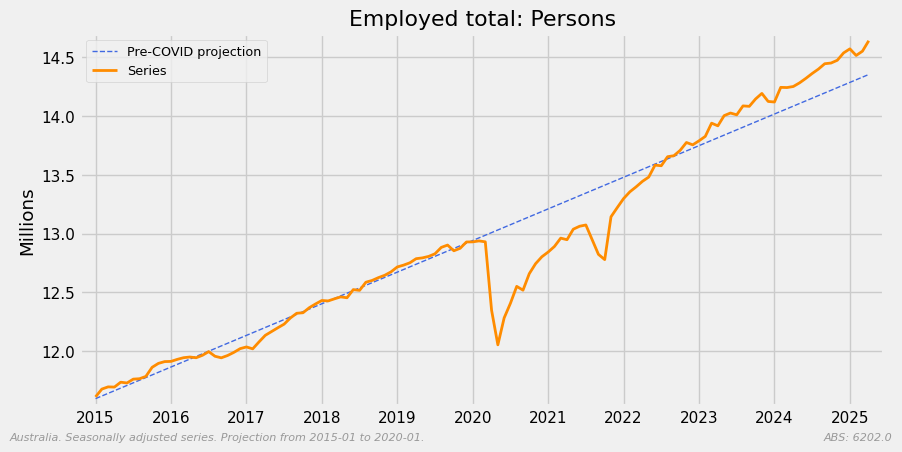

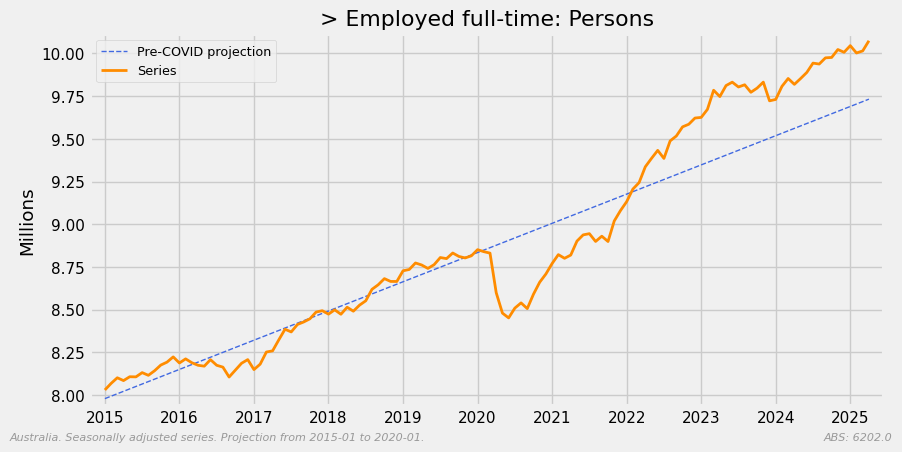

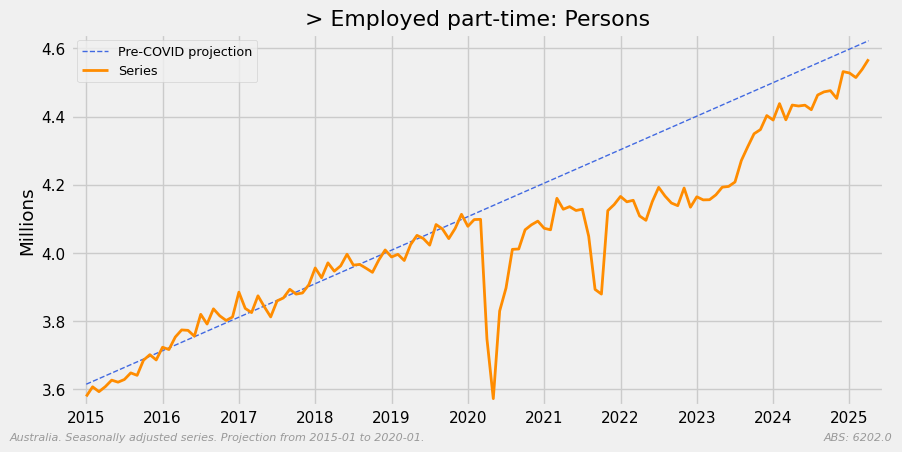

recalibrate(): Units not appropriately calibrated: Percent


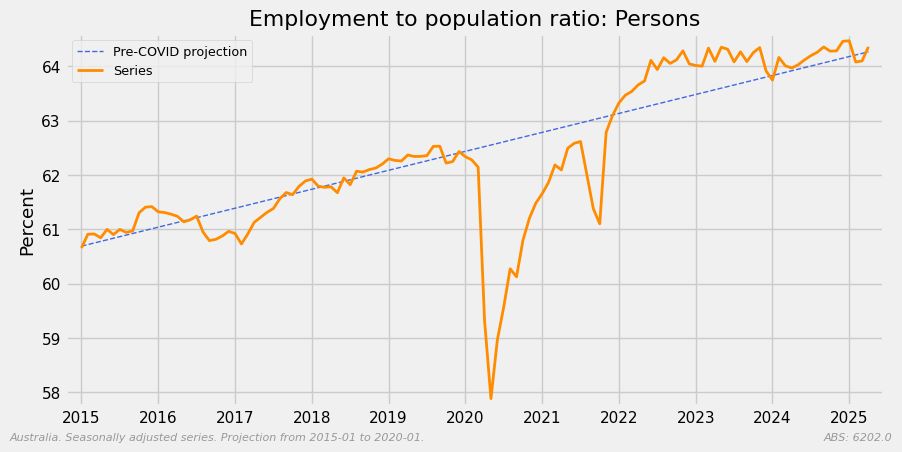

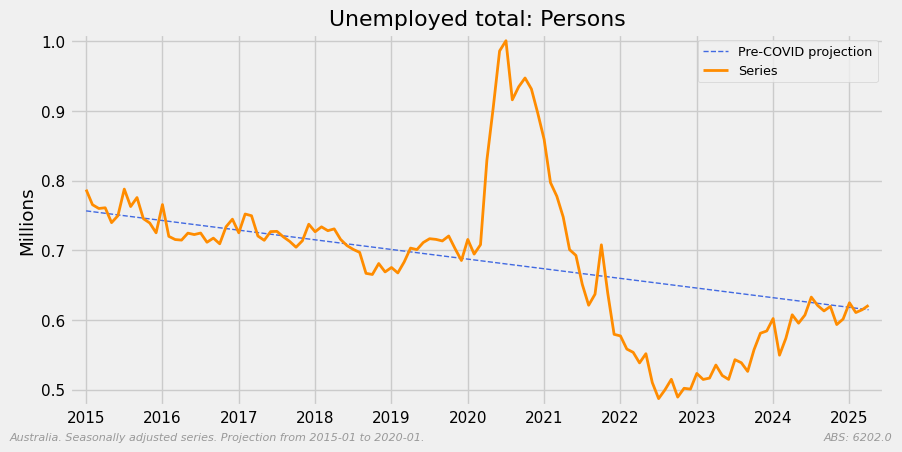

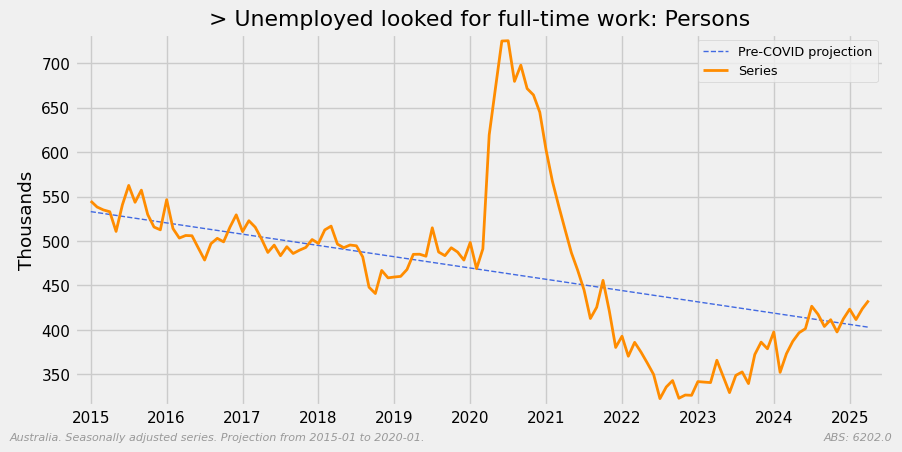

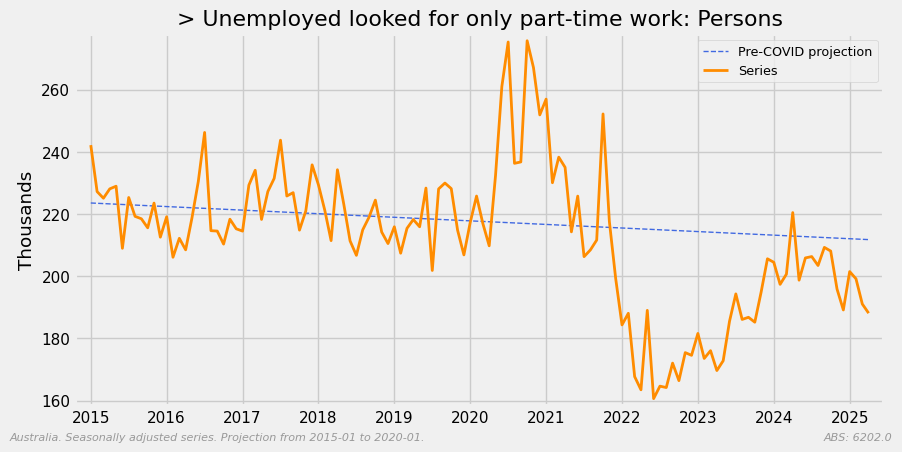

recalibrate(): Units not appropriately calibrated: Percent


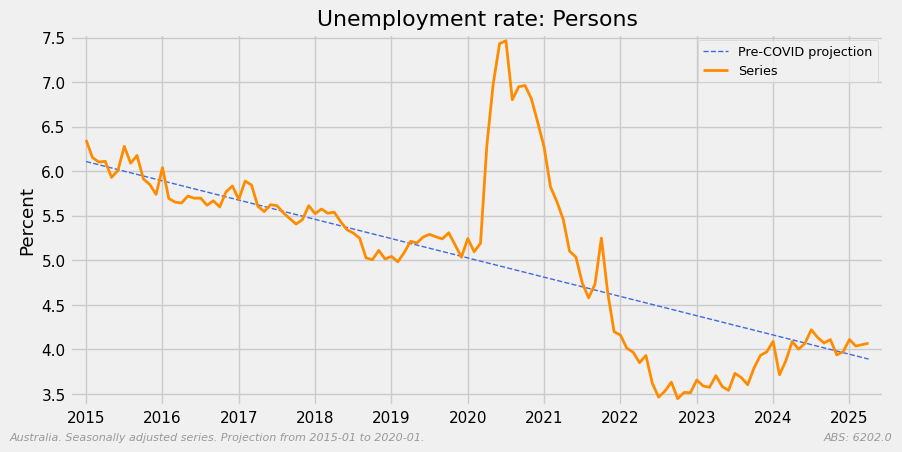

recalibrate(): Units not appropriately calibrated: Percent


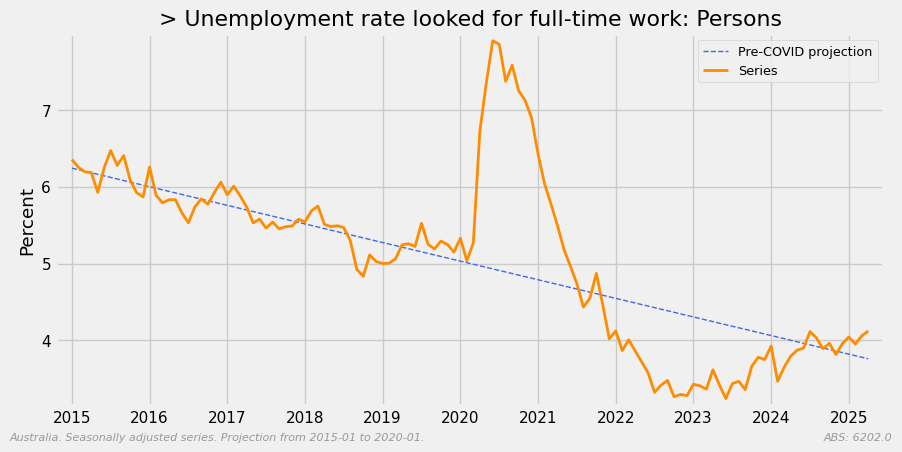

recalibrate(): Units not appropriately calibrated: Percent


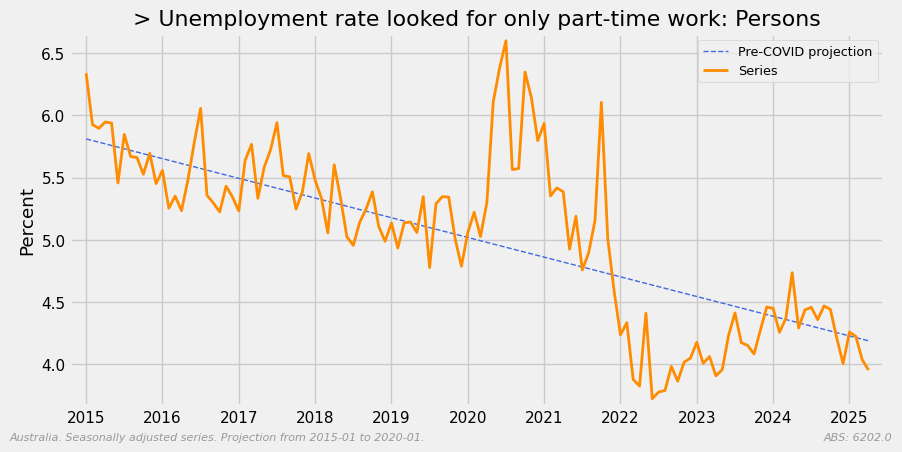

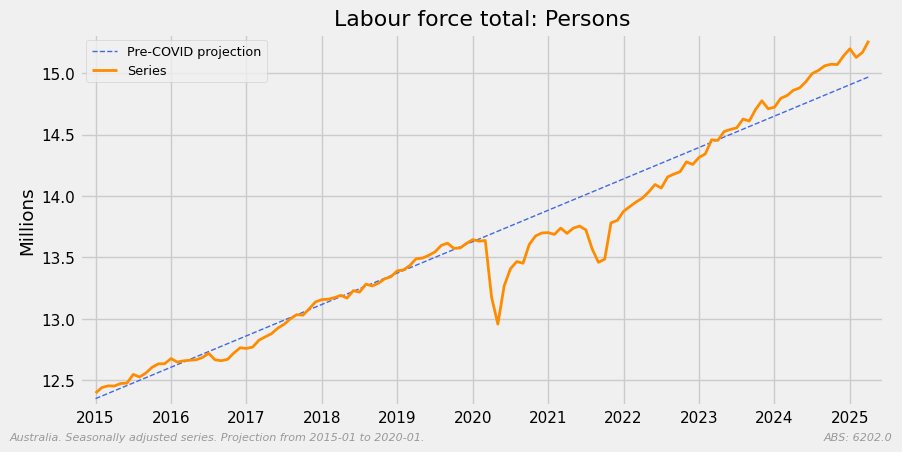

recalibrate(): Units not appropriately calibrated: Percent


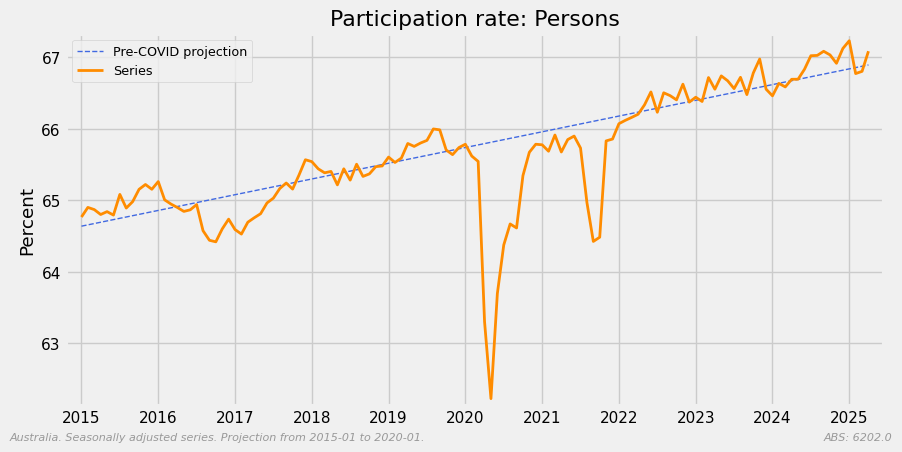

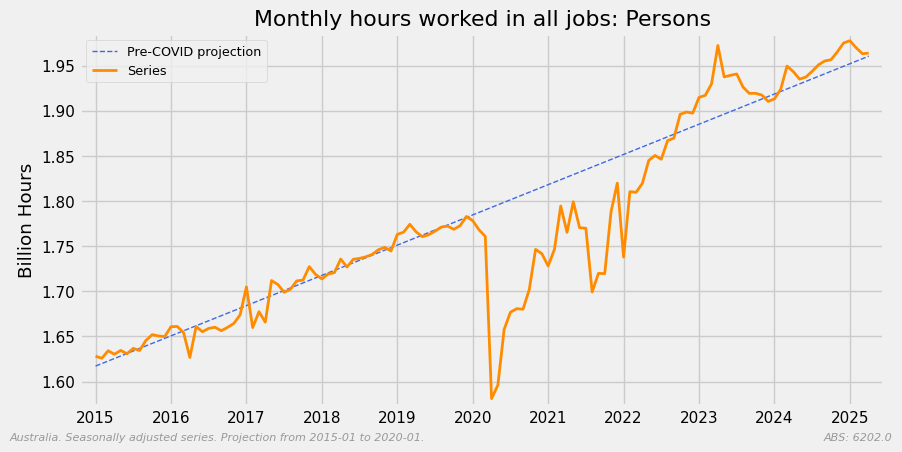

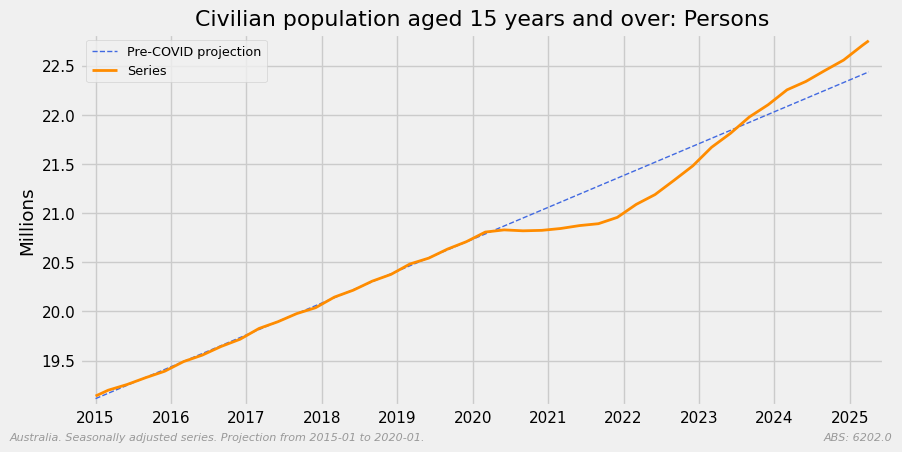

In [10]:
def covid_charts():
    """Produce pre/post COVID trajectory charts."""

    service_type = "Seasonally Adjusted"
    selector1 = {
        "Persons": mc.did,
        "6202001": mc.table,
        service_type: mc.stype,
    }
    selector2 = {
        "Monthly hours worked in all jobs ;  Persons ;": mc.did,
        "6202019": mc.table,
        service_type: mc.stype,
    }
    selector3 = {
        "Original": mc.stype,
        "6202001": mc.table,
        "Civilian population aged 15 years and over ;  Persons ;": mc.did,
    }

    for selector in (selector1, selector2, selector3):
        plot_rows_individually(
            abs_dict,
            meta,
            selector=selector,
            plot_function=mg.covid_recovery_plot,
            tags="COVID",
            rfooter=source,
            lfooter=f"Australia. {service_type.capitalize()} series. ",
            show=SHOW,
        )


covid_charts()

### State comparisons 

In [11]:
# use linestyle to help differentiate datasets ...
linestyle = {
    "style": [
        "-.",
        "-",
        "--",
        ":",
    ]
    * 3  # repeat enough to cover all series
}

recalibrate(): Units not appropriately calibrated: Percent
{'loc': 'best', 'fontsize': 'small', 'ncols': 2}


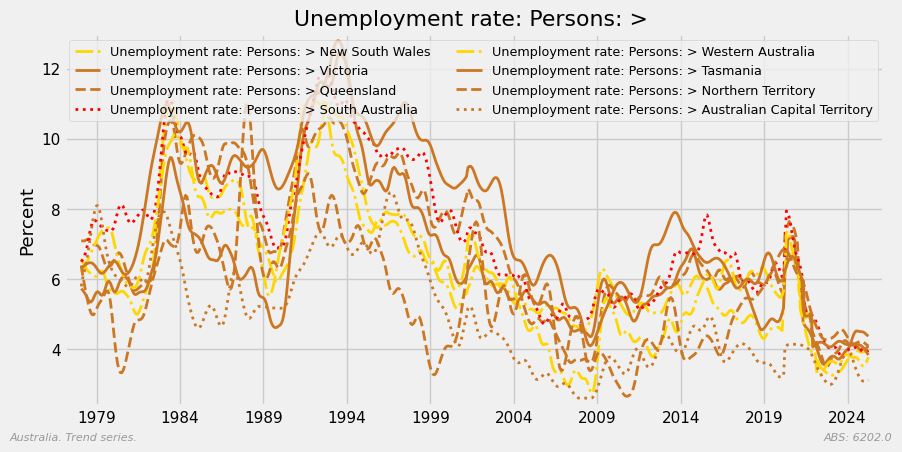

TypeError: summary_plot() got multiple values for argument 'start'

In [12]:
def state_charts():
    """Produced Unemployment and Rarticipation Rate charts for states."""

    states = (
        "New South Wales|Victoria|Queensland|South Australia"
        "|Western Australia|Tasmania|Northern Territory|Australian Capital Territory"
    )
    # service_type = "Seasonally Adjusted"
    service_type = "Trend"
    selector = {
        states: mc.did,
        service_type: mc.stype,
    }
    plot_stems = [
        "Unemployment rate ;  Persons",
        "Participation rate ;  Persons",
    ]

    for stem in plot_stems:
        xselector = selector | {stem: mc.did}
        plot_rows_collectively(
            abs_dict,
            meta,
            selector=xselector,
            regex=True,
            starts=["2000-01", RECENT],
            width=2,
            **linestyle,
            legend={"loc": "best"},
            rfooter=source,
            lfooter=f"Australia. {service_type.capitalize()} series.",
            show=SHOW,
        )

        # summary plot of Seasonally Adjusted UE rates by state
        stype = "Seasonally Adjusted"
        yselector = xselector.copy()
        yselector.pop("Trend")
        yselector[stype] = mc.stype
        rows = ra.search_abs_meta(meta, yselector, regex=True)
        names = rows[mc.did].str.split("> ").str[1].str.split(" ;").str[0].values
        ids = rows[mc.id].values
        to_get = {n: [i, 0] for n, i in zip(names[::-1], ids[::-1])}
        mg.summary_plot(
            to_get,
            abs_dict,
            meta,
            start="2000-01",
            title=f"{stem.replace("; ", "-")} - for {abs_dict['6202012'].index[-1]}",
            lfooter=f"Australia. {stype.capitalize()} series.",
            rfooter=source,
            show=SHOW,
        )


state_charts()

In [ ]:
def state_employment_growth():
    """Employed persions compared with the 2019 average / index = 100."""

    states = (
        "New South Wales|Victoria|Queensland|South Australia"
        "|Western Australia|Tasmania|Northern Territory|Australian Capital Territory"
    )
    selector = {
        states: mc.tdesc,
    }
    plot_stems = [
        ["Employed total ;  Persons ;", "Trend"],
        ["Unemployed total ;  Persons ;", "Trend"],
        ["Civilian population aged 15 years and over ;", "Original"],
    ]

    for stem, service_type in plot_stems:
        xselector = {
            **selector,
            stem: mc.did,
            service_type: mc.stype,
        }
        frame = pd.DataFrame()
        for _, row in ra.search_abs_meta(
            meta,
            xselector,
            exact=False,
            regex=True,
            verbose=False,
        ).iterrows():
            series_id, _, _, table, _ = iudts_from_row(row)
            state = row[mc.tdesc].split(" - ")[0]
            state = state.split(", ")[-1]
            frame[state] = abs_dict[table][series_id]
        if len(frame) == 0:
            continue

        for comparison_year in (2019, 2022):
            base = frame.loc[frame.index.year == comparison_year].mean()
            index_df = frame.divide(base) * 100
            index_df = index_df.loc[index_df.index.year >= comparison_year]
            index_df.columns = index_df.columns.map(state_abbr)

            title = f"{stem} cf {comparison_year} Ave.".replace(" ;", ";").replace(
                "  ", " "
            )
            line_plot(
                index_df,
                title=title,
                ylabel=f"Index ({comparison_year} = 100)",
                color=[state_colors[x] for x in index_df.columns],
                axhline={"y": 100, "lw": 0.75, "c": "#555555"},
                legend={"loc": "best", "fontsize": "x-small", "ncols": 2},
                **linestyle,
                rfooter=source,
                lfooter=f"Australia. {service_type.capitalize()} series.",
                width=2,
                show=SHOW,
            )


state_employment_growth()

### Headline Growth

In [ ]:
# 12 month change in uer v 12 month change in OCR
def uer_change():
    """Produce a chart showing the 12 month change in uer v 12 month change in OCR."""

    employed, labour_force = (
        abs_dict["6202001"]["A84423043C"],
        abs_dict["6202001"]["A84423047L"],
    )
    uer = ((1 - employed / labour_force) * 100).dropna()
    # uermin = uer - uer.rolling(13).min()
    uer12 = uer.diff(12)["1993-01-01":]
    uer12.name = "12 Month Change in Unemployment Rate"
    ax = uer12.plot(lw=1.5)
    ax.text(
        uer12.index[-1],
        uer12.iloc[-1],
        f" {uer12.iloc[-1]:.2f}",
        fontsize=9,
        va="center",
        ha="left",
    )

    rba12 = ra.read_rba_ocr().diff(12)["1993-01-01":]
    rba12.name = "12 Month Change in RBA Cash Rate"
    rba12.plot(ax=ax, lw=1.5, style="-", color="darkorange")
    ax.text(
        rba12.index[-1],
        rba12.iloc[-1],
        f" {rba12.iloc[-1]:.2f}",
        fontsize=9,
        va="center",
        ha="left",
    )

    finalise_plot(
        ax,
        title="12 Month Change in Unemployment Rate & RBA OCR",
        ylabel="Percentage Points",
        y0=True,
        rfooter=f"{source} RBA A2",
        lfooter="Australia. Seasonally adjusted. UER and its 12 month difference "
        + "calculated from the ABS LFS. RBA OCR on a monthly basis.",
        legend={"loc": "best", "fontsize": 9},
        show=SHOW,
    )


uer_change()

In [ ]:
def employment_growth():
    """Employed persons growth."""

    for stype in "Trend", "Seasonally Adjusted", "Original":
        selector = {
            "6202001": mc.table,
            "Employed total ;  Persons ;": mc.did,
            stype: mc.stype,
        }
        table, sid, _units = ra.find_abs_id(meta, selector, regex=True)
        print(stype, sid)
        employed = abs_dict[table][sid]
        growth = employed.diff(12), employed.diff(1)
        plot_growth_finalise(
            *growth,
            title=f"Employed persons - {stype} numeric growth",
            ylabel="Thousand Persons",
            from_=employed.index[-15],
            rfooter=source,
            lfooter=f"Australia. {stype} series. Monthly data.",
            annotate=10,
            annotation_rounding=0,
            y0=True,
            zero_y=True,
            show=SHOW,
        )


employment_growth()

In [ ]:
def ft_v_pt_growth():
    """Growth in FT/PT employment and FT/PT Hours.
    Can be an indicator of labour market softening or tightening."""

    # data capture - employed persons
    table = "6202001"
    stype = "Trend"
    selector = {
        table: mc.table,
        "Persons ;": mc.did,
        "Employed": mc.did,
        stype: mc.stype,
    }
    rows = ra.search_abs_meta(
        meta,
        selector,
    )
    e_data = abs_dict[table][rows[mc.id]]
    e_data.columns = rows[mc.did]
    e_unit = rows[mc.unit].iloc[0]

    # data capture - hours worked
    table2 = "6202019"
    selector = {
        table2: mc.table,
        "Monthly hours worked in all jobs": mc.did,
        "Persons ;": mc.did,
        stype: mc.stype,
    }
    rows = ra.search_abs_meta(
        meta,
        selector,
    )
    h_data = abs_dict[table2][rows[mc.id]]
    h_data.columns = rows[mc.did]
    h_unit = rows[mc.unit].iloc[0]

    # ploting the data
    recent = e_data.index[-37]  # 3 years
    for data, title, unit in (
        (e_data, "Employed persons", e_unit),
        (h_data, "Monthly hours worked", h_unit),
    ):
        for delta in 1, 3:
            difference = data.diff(delta)
            difference, u = ra.recalibrate(difference, unit)
            line_plot(
                difference,
                title=f"{title} - growth over {delta} month{'s' if delta > 1 else ''}",
                starts=(recent,),
                ylabel=f"{u}",
                rfooter=source,
                lfooter=f"Australia. {stype} series. Monthly data.",
                width=2,
                y0=True,
                show=SHOW,
            )


ft_v_pt_growth()

In [ ]:
def growth_charts(plot_stems: str, service_type: str):
    """Produce % growth charts."""

    plot_rows_individually(
        abs_dict,
        meta,
        # data selection
        selector={
            "6202001": mc.table,
            plot_stems: mc.did,
            service_type: mc.stype,
        },
        regex=True,
        # plotting
        plot_function=calc_and_plot_growth,
        from_=list(plot_times)
        + [(pd.Timestamp.today() - pd.DateOffset(months=16)).strftime("%Y-%m-%d")],
        tag="growth",
        rfooter=source,
        annotate=10,
        lfooter=f"Australia. {service_type.capitalize()} series. ",
        y0=True,
        zero_y=True,
        show=SHOW,
    )


def chart_growth():
    """Structure/select growth charts for plotting."""

    # Seasonally adjusted series
    plot_stems = "|".join(
        [
            "Employed total ;  Persons ;",
            "Unemployed total ;  Persons ;",
            "Labour force total ;  Persons ;",
        ]
    )
    service_type = "Seasonally Adjusted"
    growth_charts(plot_stems, service_type)

    # Original series
    plot_stems = "|".join(
        [
            "Civilian population aged 15 years and over ;  Persons ;",
        ]
    )
    service_type = "Original"
    growth_charts(plot_stems, service_type)


chart_growth()

In [ ]:
def growth_hours_emp():
    """Compare growth in hours worked and employed persons."""

    for growth_type, delta in ("Monthly", 1), ("Quarterly", 3), ("Annual", 12):
        for stype in "Trend", "Seasonally Adjusted":

            # data capture - employed persons
            table = "6202001"
            selector = {
                table: mc.table,
                "Employed total ;  Persons ;": mc.did,
                stype: mc.stype,
            }
            _table, series_id, _units = ra.find_abs_id(meta, selector)
            e_data = abs_dict[table][series_id]
            e_data.name = "Employed Persons"

            # data capture - hours worked
            table2 = "6202019"
            selector = {
                table2: mc.table,
                "Monthly hours worked in all jobs ;  Persons ;": mc.did,
                stype: mc.stype,
            }
            _table, series_id, _units = ra.find_abs_id(meta, selector)
            h_data = abs_dict[table2][series_id]
            h_data.name = "Hours worked in Month"

            # combined
            data = pd.concat([e_data, h_data], axis=1)
            data = data.pct_change(delta) * 100
            data = data.dropna()
            line_plot(
                data,
                starts=(data.index[-61], None),
                title=f"{growth_type} growth in employed persons and hours worked",
                ylabel="Percentage Change",
                rfooter=source,
                lfooter=f"Australia. {stype.capitalize()} series. Monthly data.",
                width=(2, 1),
                y0=True,
                tags=f"{growth_type}-{stype}",
                show=SHOW,
            )


growth_hours_emp()

### Gendered comparisons

In [ ]:
def gender_charts():
    """Produce gender comparison charts."""

    genders = ["Males", "Females"]
    colours = ["cornflowerblue", "hotpink"]

    token = "by gender"  # note: also appears in plot title
    plots = {
        # data description                       # table
        f"Employed total ;  > {token} ;": "6202001",
        f"> Employed part-time ;  > {token} ;": "6202001",
        f"> Employed full-time ;  > {token} ;": "6202001",
        f"Unemployed total ;  > {token} ;": "6202001",
        f"Labour force total ;  > {token} ;": "6202001",
        f"Unemployment rate ;  > {token} ;": "6202001",
        f"Participation rate ;  > {token} ;": "6202001",
        f"Monthly hours worked in all jobs ;  > {token} ;": "6202019",
    }

    series_type = "Seasonally Adjusted"

    for plot, table in plots.items():
        # assemble data
        collection = {}
        for gender in genders:
            this_gender = plot.replace(token, gender)

            search = {
                table: mc.table,
                series_type: mc.stype,
                this_gender: mc.did,
            }
            _, ident, units = ra.find_abs_id(meta, search)
            collection[gender] = abs_dict[table][ident]
        df = pd.DataFrame(collection)
        df, units = ra.recalibrate(df, units)

        title = f"Australia: {plot}".replace(" ;", "").replace("  ", " ")
        line_plot(
            df,
            starts=plot_times,
            tags=plot_tags,
            color=colours,
            title=title,
            ylabel=units,
            rfooter=f"{source} {table}",
            lfooter=f"{series_type.capitalize()} series",
            width=1.5,
            show=SHOW,
        )


gender_charts()

### Hours worked - Market sector vs Non-market sector

In [ ]:
def hw_by_sector():
    """Produce hours worked by sector charts."""

    table = "6202021"
    common = {
        "width": 2,
        "y0": True,
        "rfooter": f"{source} Table:{table[-2:]}",
        "lfooter": "Australia. Quarterly data. ",
        "show": SHOW,
    }
    set1 = {
        "Market Sector": ";  Market ;",
        "Non-Market Sector": ";  Non-market ;",
    }
    set2 = {
        "Education and Training": "Education and Training",
        "Rest of Non-Market Sector": "Rest of Non-market",
    }
    set3 = {
        "Agriculture, Forestry and Fishing": "Agriculture, Forestry and Fishing",
        " Rest of Market Sector": "Rest of Market",
    }

    for wanted, tag in zip((set1, set2, set3), ("all", "non-market", "market")):
        annual, decadal, raw = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        for label, stem in wanted.items():
            selector = {
                table: mc.table,
                stem: mc.did,
            }
            _, series_id, units = ra.find_abs_id(meta, selector)
            series = abs_dict[table][series_id]
            annual[label] = series.pct_change(4) * 100
            decadal[label] = (((series / series.shift(40)) ** 0.1) - 1) * 100
            raw[label] = series
        raw, units = ra.recalibrate(raw, units)
        common["tags"] = tag
        line_plot(
            raw,
            title="Hours Worked by Sector",
            ylabel=units,
            **common,
        )
        line_plot(
            annual,
            title="Annual Growth in Hours Worked by Sector",
            ylabel="Percentage Change",
            **common,
        )
        line_plot(
            decadal,
            title="Decadal Compound Annual Growth in Hours Worked by Sector",
            ylabel="Annual Percentage Change",
            **common,
        )


hw_by_sector()

## Finished

In [ ]:
# watermark
%load_ext watermark
%watermark -u -t -d --iversions --watermark --machine --python --conda

In [ ]:
print("Finished")